Importation des libraries

In [7]:
import gzip
import json
import numpy as np
from collections import defaultdict

Variable pour sauvegarder le chemin de travail

In [8]:
workpath="/data/jmoreno/Datasets/signalmedia/"

Pointeur au fichier à lire

In [9]:
f=gzip.open(workpath+'signalmedia-1k.jsonl.gz','rb')

Lecture de tous les titres

In [10]:
docs=[json.loads(s.decode('utf-8')) for s in f.readlines()]
titres=[x['title'] for x in docs]
content=[x['content'] for x in docs]
print(len(titres))
titres[:10]

1000


['Worcester breakfast club for veterans gives hunger its marching orders',
 'Jumpshot Gives Marketers Renewed Visibility Into Paid and Organic Keywords With Launch of Jumpshot Elite',
 'The Return Of The Nike Air Max Sensation Has 80’s Babies Hyped!',
 'This New Dating App Will Ruin Your Internet Game',
 'Pay up or face legal action: DBKL',
 'Euro up; USD, Pound and Yen down',
 'THE INFLUENCE OF OUR WORDS',
 "Hands on with Apple's iPhone 6s, iPad Pro and Apple TV",
 'Harwood Feffer LLP Announces Investigation of VASCO Data Security International, Inc.',
 'What will happen to Peta Credlin and Brian Loughnane, Liberal power couple?']

In [6]:
def sentense2cleanTokens(sent):
    sent = sent.lower()
    sent = "".join([x if x.isalpha() else " " for x in sent])
    sent = " ".join(sent.split())
    return sent

In [67]:
cleantitres=[sentense2cleanTokens(x) for x in content]
cleantitres[:10]

['veterans saluted worcester s first ever breakfast club for ex soldiers which won over hearts minds and bellies the worcester breakfast club for hm forces veterans met at the postal order in foregate street at am on saturday the club is designed to allow veterans a place to meet socialise eat and drink giving hunger and loneliness their marching orders father of two dave carney aged of merrimans hill worcester set up the club after being inspired by other similar clubs across the country he said as you can see from the picture we had a good response five out of the that attended said they saw the article in the newspaper and turned up we even had an old chap travel from droitwich and he was late on parade by three hours it s generated a lot of interest and i estimate from other veterans who saw the article that next month s meeting will attract about people onwards and upwards he said the management at the pub had been extremely hospitable to them mr carney said they bent over backwar

In [5]:
def sentenses2vocabs(sents,th=0):
    fullcount=defaultdict(int)
    for x in sents:
        for w in x.split():
            fullcount[w]+=1
    vocabset = set(key for key, value in fullcount.items() if value >= th)
    ivocab=[]
    vocab={}
    for i,x in enumerate(vocabset):
        vocab[x]=i
        ivocab.append(x)
    return vocabset,vocab,ivocab

In [72]:
sentenses2vocabs(cleantitres[:3],2)

({'a',
  'ability',
  'about',
  'access',
  'across',
  'actual',
  'after',
  'air',
  'all',
  'also',
  'am',
  'analytics',
  'and',
  'any',
  'are',
  'article',
  'as',
  'at',
  'author',
  'available',
  'back',
  'basketball',
  'been',
  'behavior',
  'being',
  'breakfast',
  'but',
  'by',
  'carney',
  'clicks',
  'club',
  'clubs',
  'com',
  'company',
  'complete',
  'conversions',
  'could',
  'country',
  'customer',
  'customers',
  'data',
  'distinctive',
  'doing',
  'drink',
  'each',
  'elite',
  'even',
  'ever',
  'fan',
  'first',
  'for',
  'forces',
  'francisco',
  'from',
  'generated',
  'giving',
  'go',
  'good',
  'group',
  'had',
  'has',
  'have',
  'he',
  'home',
  'how',
  'i',
  'if',
  'in',
  'inferred',
  'information',
  'insight',
  'into',
  'is',
  'it',
  'its',
  'journey',
  'jumpshot',
  'keywords',
  'management',
  'marketers',
  'marketing',
  'max',
  'meeting',
  'million',
  'month',
  'months',
  'more',
  'mr',
  'mw',
  'n

In [14]:
def sentenses2matrix(sents,vocab):
    tf = np.zeros((len(sents), len(vocab)))
    for i,s in enumerate(sents):
        for w in s.split():
            if w in vocab:
                tf[i][vocab[w]]+=1
    return tf

In [128]:
vocabset500,vocab500,ivocab500 = sentenses2vocabs(cleantitres,500)
tf500=sentenses2matrix(cleantitres,vocab500)
tf500

array([[ 7.,  7.,  1., ...,  0.,  1.,  2.],
       [ 0.,  6.,  0., ...,  2.,  0.,  2.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [72]:
vocabset,vocab,ivocab = sentenses2vocabs(cleantitres,5)
tf=sentenses2matrix(cleantitres,vocab)
tf.shape

(1000, 8227)

In [56]:
def evaluate_vectors(W, vocab, ivocab):
    """Evaluate the trained word vectors on a variety of tasks"""
    filenames = ['capital-common-countries.txt']
    split_size = 100
    correct_tot = 0 # count correct questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words
    for i in range(len(filenames)):
        with open('%s/%s' % (workpath, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]
#
        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T
#
        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))
#
            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])
            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)
#
            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf
#
            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()
#
        val = (ind4 == predictions) # correct predictions
        print(np.array(data)[val][:10])
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
#
        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
#
    print('Questions seen/total: %.2f%% (%d/%d)' %
        (100 * count_tot / float(full_count), count_tot, full_count))
    print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))

In [57]:
W = np.zeros(tf.T.shape)
for i,v in enumerate(tf.T):
    W[i]=v/np.linalg.norm(v)


In [58]:
evaluate_vectors(W,vocab,ivocab)

[['moscow' 'russia' 'beijing' 'china']
 ['paris' 'france' 'beijing' 'china']]
capital-common-countries.txt:
ACCURACY TOP1: 1.82% (2/110)
Questions seen/total: 21.74% (110/506)
Total accuracy: 1.82%  (2/110)


In [59]:
def distance(a,b):
    return np.linalg.norm(a-b)

In [236]:
def kmeans(docs, k, niter=10):
    centroids=np.random.rand(k,len(docs[0]))
    for i in range(niter):
        docsInCluster=defaultdict(list)
        # Document assignation
        for idoc,doc in enumerate(docs):
            distances=[distance(doc,c) for c in centroids]
            docsInCluster[np.argmin(distances)].append(idoc)
        #Cluster redifinition
        for ic in docsInCluster:
            centroids[ic]=np.average(docs[docsInCluster[ic]],0)
        #Error
        print("Iter=",i,"Error=",sum([distance(c,docs[d]) for ic, c in enumerate(centroids) for d in docsInCluster[ic]]))
    return docsInCluster,centroids

In [262]:
from sklearn import datasets
varied = datasets.make_blobs(1500,centers=3,cluster_std=[1.0, 2.0, 0.5])
%matplotlib notebook

import matplotlib.pyplot as plt
colors = np.array(['#377eb8', '#ff7f00', '#4daf4a'])

<IPython.core.display.Javascript object>


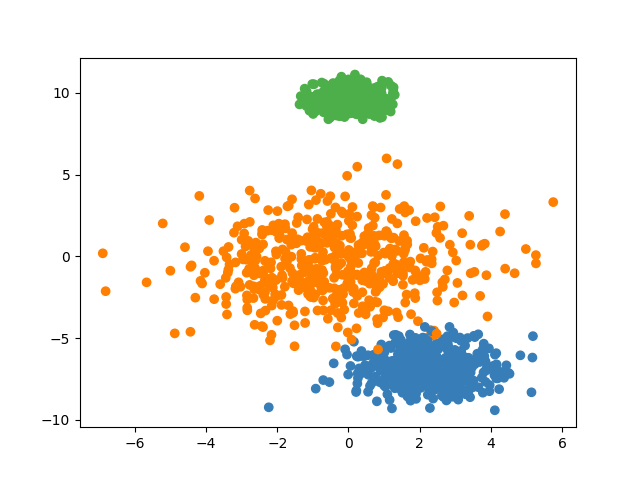

In [263]:
plt.scatter(varied[0][:,0],varied[0][:,1], color=colors[varied[1]])

Iter= 0 Error= 3120.30751089
Iter= 1 Error= 2192.36308828
Iter= 2 Error= 2147.95484992
Iter= 3 Error= 2145.7619118
Iter= 4 Error= 2145.60227483
Iter= 5 Error= 2145.60227483
Iter= 6 Error= 2145.60227483
Iter= 7 Error= 2145.60227483
Iter= 8 Error= 2145.60227483
Iter= 9 Error= 2145.60227483
[[ 0.08982057  9.62547155]
 [-0.49236395 -0.29982495]
 [ 2.15387892 -6.71941137]]


<IPython.core.display.Javascript object>


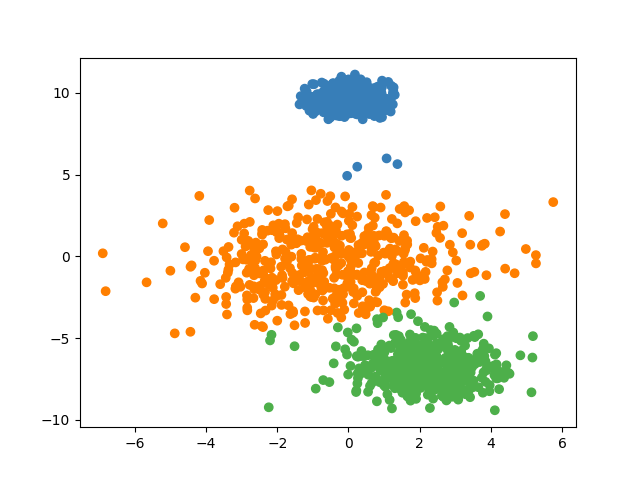

In [265]:
clusters,centroids = kmeans(varied[0],3)
pred=np.array([-1 for i in range(len(varied[0]))])
for key in clusters:
    for d in clusters[key]:
        pred[d]=key
print(centroids)
plt.scatter(varied[0][:,0],varied[0][:,1], color=colors[pred])

In [252]:
clusters = kmeans(tf,100)
print(len(clusters))
clusters

Iter= 0 Error= 86616.3097705
Iter= 1 Error= 79286.7886386
Iter= 2 Error= 77202.5575444
Iter= 3 Error= 75969.0081328
Iter= 4 Error= 75405.3999061
Iter= 5 Error= 75109.8511521
Iter= 6 Error= 75073.4421984
Iter= 7 Error= 75074.2706895
Iter= 8 Error= 75074.5113264
Iter= 9 Error= 75075.383906
2


(defaultdict(list,
             {0: [64, 79, 210, 507, 991],
              1: [440],
              2: [813],
              3: [597],
              4: [279, 485, 552, 711, 744, 817],
              5: [123,
               131,
               163,
               189,
               208,
               246,
               249,
               306,
               320,
               335,
               381,
               388,
               391,
               399,
               438,
               457,
               653,
               663,
               669,
               675,
               717,
               720,
               730,
               751,
               765,
               767,
               821,
               909,
               937,
               968,
               971],
              6: [133, 431, 517],
              7: [297, 535, 762],
              8: [81, 142, 636, 956, 995],
              9: [185, 319, 609],
              10: [413, 713],
              11: [

In [113]:
[titres[x] for x in clusters[0]]

['Thomas Rhett pulls a Swift: Is country music\xa0still country music when rap, soul and EDM are included?',
 'Punk’s Not Passed',
 'How To Employ Effective SEO Practices',
 'Heritage Texas Properties Names Chaille Ralph as New President',
 'Picking up a Personal in Judgments',
 'Usage This Guidance To End up being An Interior Decorating Pro',
 'Nicola Sturgeon announces national testing for primary schools',
 "The Volcano House, Palazzo di Amore, the Flintstone House: What's the real worth of an over-the-top home?",
 'Best Prices in Town: Week of August 16, 2015',
 'Mental glitch that’s making us spend',
 'Tide takes down MTSU in Tuscaloosa',
 'My Troubles with Landscape Fabric: Part 1',
 "PETE'S PROBABLY NON-COMPREHENSIVE VISUAL NOVEL PRIMER",
 'Tillage timing influences nitrogen availability and loss on organic farms']

In [238]:
import random

def kmeans2(docs, k, niter=10):
    centroids=docs[random.sample([i for i in range(len(docs))],k)]
    for i in range(niter):
        docsInCluster=defaultdict(list)
        # Document assignation
        for idoc,doc in enumerate(docs):
            distances=[distance(doc,c) for c in centroids]
            docsInCluster[np.argmin(distances)].append(idoc)
        #Cluster redifinition
        for ic in docsInCluster:
            centroids[ic]=np.average(docs[docsInCluster[ic]],0)
        #Error
        print("Iter=",i,"Error=",sum([distance(c,docs[d]) for ic, c in enumerate(centroids) for d in docsInCluster[ic]]))
    return docsInCluster

In [239]:
clusters = kmeans2(tf,100,niter=10)
print(len(clusters))
clusters

Iter= 0 Error= 79280.4180066
Iter= 1 Error= 74288.3185108
Iter= 2 Error= 73553.8883966
Iter= 3 Error= 73359.8037999
Iter= 4 Error= 73210.0162809
Iter= 5 Error= 73209.9977425
Iter= 6 Error= 73209.2128934
Iter= 7 Error= 73209.2128934
Iter= 8 Error= 73209.2128934
Iter= 9 Error= 73209.2128934
100


defaultdict(list,
            {0: [19],
             1: [621],
             2: [523],
             3: [532],
             4: [872, 955],
             5: [539],
             6: [59],
             7: [7, 505, 561, 646, 732, 761],
             8: [48],
             9: [897, 994],
             10: [374],
             11: [49, 691],
             12: [969],
             13: [187],
             14: [941],
             15: [560],
             16: [541],
             17: [991],
             18: [255],
             19: [695],
             20: [3, 309, 738],
             21: [358],
             22: [327, 354],
             23: [570],
             24: [346],
             25: [229],
             26: [728],
             27: [123],
             28: [31],
             29: [55, 880],
             30: [493],
             31: [821],
             32: [970],
             33: [741],
             34: [6,
              20,
              26,
              87,
              110,
              125,
             

In [241]:
[titres[x] for x in clusters[7]]

["Hands on with Apple's iPhone 6s, iPad Pro and Apple TV",
 'Amazon Has 6 New Devices—And an Actual Plan for Hardware',
 "PM's rich and powerful enemies",
 'IHSE Exhibits Draco Tera Matrix Switch With ExtremeUSB(R) 3.0 Extension Technology for Broadcast Applications at IBC2015 Show',
 'SAML and Active Directory Federation Services (ADFS) Integration Errors, Events, Possible causes and Fixes',
 "Apple Daily: Apple Special Event Primer, Glowing 'Steve Jobs' Review; Apple and A.I."]

In [130]:
l2norm = np.sqrt((tf500 * tf500).sum(axis=1))
tf500 /l2norm.reshape(len(tf500),1)

array([[ 0.15904984,  0.15904984,  0.02272141, ...,  0.        ,
         0.02272141,  0.04544281],
       [ 0.        ,  0.12374422,  0.        , ...,  0.04124807,
         0.        ,  0.04124807],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.06884284,  0.        ],
       ..., 
       [ 0.        ,  0.24253563,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.60302269,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [138]:
l2norm = np.sqrt((tf * tf).sum(axis=1))
tfnorm = tf /l2norm.reshape(len(tf),1)
sum([x*x for x in tfnorm[0]])

1.0000000000000004

In [131]:
clusters = kmeans2(tfnorm,100)
print(len(clusters))
clusters

99


defaultdict(list,
            {0: [126, 245, 483, 829, 949],
             1: [30, 53, 303, 473, 587, 793, 961],
             2: [191, 519, 873, 986],
             3: [186, 239, 974],
             4: [66, 276, 283, 403, 480, 530, 838, 844, 894, 942, 944, 968],
             5: [70, 104, 234, 241, 549, 564, 912],
             6: [41, 157, 217, 238, 243, 416, 521, 585, 668, 832, 880],
             7: [101, 160, 512, 868],
             8: [43, 129, 172, 312, 342, 368, 427, 430, 506, 625, 644],
             9: [20,
              36,
              81,
              105,
              462,
              478,
              493,
              505,
              509,
              510,
              535,
              540,
              560,
              562,
              591,
              660,
              701,
              713,
              721,
              738,
              774,
              867,
              876,
              881,
              882],
             10: [142, 545, 56

In [132]:
[titres[x] for x in clusters[0]]

['Victor Cruz expected to play in Week 4',
 'Study: Is Alzheimer’s transmissible between people?',
 '1987 Billy Meier foretold Russia will attack and conquer Iran',
 'NSA/CSS Employees Reaffirm Their Oath to the Constitution',
 'Volkswagen scandal will have personnel consequences: German State Economy Minister']

In [148]:
def sentenses2matrixTFIDF(sents,vocab):
    tf = np.zeros((len(sents), len(vocab)))
    idf = np.zeros(len(vocab))
    for i,s in enumerate(sents):
        cont = [x for x in s.split() if x in vocab]
        for w in cont:
            tf[i][vocab[w]]+=1
        for w in set(cont):
            idf[vocab[w]]+=1
    return tf*np.log(len(sents)/idf)

In [163]:
tfidf=sentenses2matrixTFIDF(cleantitres,vocab)
tfidf

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [165]:
clusters = kmeans2(tfidf,100)
print(len(clusters))
clusters

99


defaultdict(list,
            {0: [460, 817],
             1: [6, 513, 865, 993],
             2: [61, 187, 207, 388, 456, 477, 545, 575, 866],
             3: [385],
             4: [26, 485, 732, 738, 881],
             5: [49, 54, 101, 324, 381, 599, 628, 671, 753, 936, 971],
             6: [53,
              71,
              104,
              113,
              128,
              130,
              144,
              190,
              203,
              206,
              219,
              234,
              238,
              243,
              266,
              284,
              292,
              296,
              303,
              308,
              314,
              336,
              337,
              372,
              377,
              386,
              416,
              417,
              441,
              445,
              471,
              521,
              559,
              564,
              580,
              583,
              585,
              58

In [169]:
[titres[x] for x in clusters[0]]

['Baltimore bike shop setting itself apart, earning national acclaim',
 'Winners honoured at 18th Annual Business Day BASA Awards, partnered by Hollard']

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=5)
tfidfsk = tfidf_vectorizer.fit_transform(cleantitres)
tfidfsk.shape

(1000, 6013)

In [243]:
clusters = kmeans2(tfidfsk.todense(),100, niter=30)
print(len(clusters))
clusters

Iter= 0 Error= 847.024973215
Iter= 1 Error= 844.36415894
Iter= 2 Error= 843.109021799
Iter= 3 Error= 843.001520423
Iter= 4 Error= 842.904308757
Iter= 5 Error= 842.799256581
Iter= 6 Error= 842.741972292
Iter= 7 Error= 842.61131506
Iter= 8 Error= 842.587849116
Iter= 9 Error= 842.552333621
Iter= 10 Error= 842.527094907
Iter= 11 Error= 842.527094907
Iter= 12 Error= 842.527094907
Iter= 13 Error= 842.527094907
Iter= 14 Error= 842.527094907
Iter= 15 Error= 842.527094907
Iter= 16 Error= 842.527094907
Iter= 17 Error= 842.527094907
Iter= 18 Error= 842.527094907
Iter= 19 Error= 842.527094907
Iter= 20 Error= 842.527094907
Iter= 21 Error= 842.527094907
Iter= 22 Error= 842.527094907
Iter= 23 Error= 842.527094907
Iter= 24 Error= 842.527094907
Iter= 25 Error= 842.527094907
Iter= 26 Error= 842.527094907
Iter= 27 Error= 842.527094907
Iter= 28 Error= 842.527094907
Iter= 29 Error= 842.527094907
100


defaultdict(list,
            {0: [75, 357, 490, 668, 902],
             1: [293, 400],
             2: [135, 183, 337, 550, 762],
             3: [78, 588],
             4: [92,
              105,
              176,
              193,
              241,
              247,
              316,
              318,
              356,
              366,
              384,
              480,
              491,
              497,
              535,
              618,
              701,
              742,
              747,
              750,
              772,
              792,
              806,
              823,
              826,
              867,
              916,
              922,
              934,
              937],
             5: [559],
             6: [219, 514, 740, 825],
             7: [58, 911],
             8: [185, 475, 536, 699, 851, 976],
             9: [68,
              79,
              106,
              163,
              165,
              221,
              261,

In [244]:
[titres[x] for x in clusters[0]]

['20-Sep-2015 02:19',
 'I despise my EHR.  But I’m still using it.',
 'Bajaj Auto August sales increase',
 'Bond Market Update: 11-Sep-15 02:40 ET',
 'Jobless rates in every Wisconsin city, county drops']

In [184]:
from sklearn.cluster import KMeans as skkmeans
clusters = skkmeans(n_clusters=100).fit(tfidfsk.todense())
print(len(list(set(clusters.labels_))))
clusters.labels_

100


array([35, 71, 46, 97,  6, 90, 21, 33, 32, 24, 64, 15, 82,  8, 31, 93, 46,
       17,  7, 47, 65, 27, 37, 24, 13, 20, 64, 90, 26, 94, 47, 13, 66, 46,
       91, 19, 13, 63, 45, 40, 26,  1, 35, 37, 91, 46, 49,  1, 13, 45, 64,
       19, 45, 26, 63, 13, 73, 13, 26, 34, 21,  6, 63,  2, 11, 31, 43, 37,
       22, 64, 72, 15, 10, 64, 81, 32, 27, 21, 29,  2, 59, 37, 13,  7, 15,
       46, 90, 63, 11, 63, 63, 36, 36, 37, 65,  5, 16, 50, 26, 36, 46, 83,
       66, 82,  4, 29, 69, 35, 13, 16, 28, 31, 21, 26, 13, 91, 62, 15,  6,
       26, 24, 13,  6, 86, 30, 46, 19, 13, 26, 64, 95, 30, 64, 66, 46, 92,
       64, 53, 13,  4, 44, 89, 17, 65, 26, 83, 37, 13, 47, 40, 50, 13, 89,
       66,  8, 17, 84, 80, 86, 13, 40, 21, 41, 52, 46, 52, 86, 49, 13, 16,
       13, 41, 26, 27, 82, 45, 36, 13, 41, 13, 89, 27, 81, 92, 63, 36, 93,
       26, 14, 80, 26, 26, 27, 36, 37, 64,  2, 54, 13, 93, 45, 91, 19, 61,
       11, 13, 36, 46, 30, 13, 13, 45, 13, 46, 13, 10, 53,  5, 46, 85, 45,
       69, 56, 13, 44, 26

In [185]:
[titres[i] for i,x in enumerate(clusters.labels_) if x ==0]

['Canterbury Times published Bisto products recalled over fears they contain METAL',
 'Byrd House Market Today']

In [83]:
W = np.zeros(tfidfsk.todense().T.shape)
for i,v in enumerate(tfidfsk.todense().T):
    W[i]=v/np.linalg.norm(v)
ivocab = tfidf_vectorizer.get_feature_names()
vocab={}
for i,word in enumerate(ivocab):
    vocab[word]=i
evaluate_vectors(W,vocab,ivocab)

[['madrid' 'spain' 'beijing' 'china']
 ['paris' 'france' 'beijing' 'china']
 ['tokyo' 'japan' 'beijing' 'china']]
capital-common-countries.txt:
ACCURACY TOP1: 10.00% (3/30)
Questions seen/total: 5.93% (30/506)
Total accuracy: 10.00%  (3/30)


In [70]:
W.shape

(6013, 1000)